### This notebook contains all of the code to generate the plots of the noisy simulations in the SC21 paper.
#### To run these, both HybridQ and QuTiP are required to be installed.

In [1]:
import time
import numpy as np
from itertools import product
from typing import List

from hybridq.gate import Gate
from hybridq.circuit.simulation import simulate
from hybridq.extras.random import get_rqc

# density matrix imports
from hybridq.dm.circuit import Circuit as SuperCircuit
from hybridq.dm.circuit.simulation import simulate as dm_simulate
from hybridq.noise.utils import add_depolarizing_noise
from hybridq.noise.channel.utils import ptrace
from hybridq.noise.channel import GlobalDepolarizingChannel, LocalDepolarizingChannel

import qutip as qt
from qutip.qip.operations import expand_operator

# for plotting
from matplotlib import pyplot as plt
from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# rc('text', usetex=True)

# qutip specs
qt.about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Jake Lishman and Simon Cross.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      4.7.0.dev0+nogit
Numpy Version:      1.19.2
Scipy Version:      1.5.0
Cython Version:     0.29.24
Matplotlib Version: 3.2.1
Python Version:     3.8.5
Number of CPUs:     4
BLAS Info:          INTEL MKL
OPENMP Installed:   True
INTEL MKL Ext:      True
Platform Info:      Darwin (x86_64)
Installation path:  /Users/jeff/opt/anaconda3/envs/hybridq/lib/python3.8/site-packages/qutip-4.7.0.dev0+nogit-py3.8-macosx-10.9-x86_64.egg/qutip
Please cite QuTiP in your publication.

## A couple helper functions for QuTiP simulations

In [2]:
I = np.diag([1, 1])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.diag([1, -1])
PAULIS = [I, X, Y, Z]


def depolarizing_channel(p: float, nq: int = 1):
    """
    Depolarizing channel of nq qubits, with depolarizing probability `p`.
    That is, it defines the channel (1-p) rho + (p/d)I
    where I is the identity matrix, and d=2**nq the dimension.
    
    Returns a tuple of the weighted Kraus operators
    """
    def _kron_prod(matrices):
        a = matrices[0]
        for i in range(1, len(matrices)):
            a = np.kron(a, matrices[i])
        return a

    all_paulis = list(product(*[PAULIS for _ in range(nq)]))
    ops = [_kron_prod(sigmas) for sigmas in all_paulis]
    norm = p / 4**nq  # normalize by number of pauli strings
    p0 = 1 - p + norm
    probs = [norm] * len(all_paulis)
    probs[0] = p0  # identity
    if not np.all([0 <= pi <= 1 for pi in probs]):
        raise ValueError(f'Input probability {p} does note define valid map')
    return tuple(
        np.sqrt(probs[i]) * o for i, o in enumerate(ops) if probs[i] != 0)


def qt_apply(rho: qt.Qobj, krauses: List[qt.Qobj], targets: List[int]):
    """
    Apply Krauses on qutip object.
    
    Given a density matrix rho, apply the Kraus
    operators on the targets, to return
    sum_i K_i rho K_i^dagger
    """

    N = len(rho.dims[0])
    rho_copy = 0 * rho
    for k in krauses:
        if not isinstance(k, qt.Qobj):
            k = qt.Qobj(k, dims=[[2] * len(targets), [2] * len(targets)])
        K = expand_operator(k, N, targets=targets)
        rho_copy += K * rho * K.dag()
    return rho_copy

## first a check that a simple density matrix simulation in HybridQ gives the correct results, comparing to an easy to solve model

In [3]:
steps = range(250)  # time steps for simulation 
p = 0.01            # depolarizing probability
theta = 0.05        # rotation angle for unitary RZ

# Z rotation
RZ = Gate('RZ', qubits=[0], params=[theta])
print("RZ:")
print(RZ.matrix())
print()

# Depolarizing channel on qubit 0
depol = GlobalDepolarizingChannel([0], p=p)

# each layer is a rotation followed by depolarizing
all_gates = [RZ] + [depol]

# make into a circuit
C = SuperCircuit(all_gates)

print("|+><+| = ")
rho = np.ones((2, 2)) / 2
print(rho)
print()

X_expec = []
for t in steps:
    print(f"{t} ", end='')
    rho = dm_simulate(C, rho, optimize='evolution-einsum')
    
    X_expec += [(X @ rho).trace()]
    
print('\n')
print("rho(t) = ")
print(rho)

RZ:
[[0.99968752-0.0249974j 0.        +0.j       ]
 [0.        +0.j        0.99968752+0.0249974j]]

|+><+| = 
[[0.5 0.5]
 [0.5 0.5]]

0 1 2 3 4 

/Users/jeff/opt/anaconda3/envs/hybridq/lib/python3.8/site-packages/hybridq/gate/gate.py:444: UserWarning: Using default number of qubits 'n_qubits=1'.
  warn("Using default number of qubits 'n_qubits=1'.")


5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 

rho(t) = 
[[0.50000058+0.j         0.0404398 +0.00268796j]
 [0.0404398 -0.00268796j 0.50000058+0.j        ]]


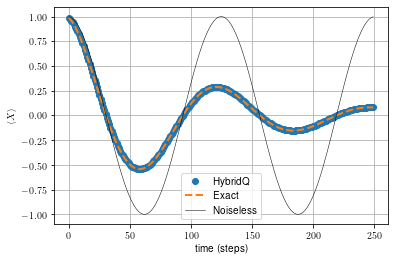

In [4]:
fig, ax = plt.subplots(1)
sa = np.array(steps) + 1  # offset

y1 = np.cos(theta * sa) * (1 - p)**sa
ax.plot(steps, np.real(X_expec), 'o', label=f'HybridQ')
ax.plot(steps, y1, '--', label='Exact', linewidth=2)
ax.plot(steps, np.cos(theta * sa), 'k-', label='Noiseless', linewidth=0.5)

ax.set_xlabel(r'time (steps)')
ax.set_ylabel(r'$\langle X \rangle$')
ax.grid()
ax.legend()

# now we check a simple density matrix simulation that HybridQ and QuTiP give the same results. In particular, we apply local depolarizing noise to each qubit of a random state. We also time this.

In [5]:
sizes = range(1, 12)

# since we use a random state below, let's fix the seed for exact reproducability
np.random.seed(1)

# try both backends
backend = ['evolution-hybridq', 'evolution-einsum'][0]

timing_data = {'qt': [], 'hq': []}
for N in sizes:
    print(f'{N} ', end='')

    # get a random density matrix to simulate from QuTiP
    rho_qt = qt.rand_dm(2**N, dims=[[2] * N, [2] * N])
    # density matrix with appropriate dimensions for HybridQ
    rho_numpy = np.reshape(rho_qt.full(), (2, ) * 2 * N)

    # different probabilities for each qubit
    depol_probs = [0.05 * (n + 1) for n in range(N)]

    # first do the HybridQ simulation
    t1_hq = time.time()
    qubits = tuple(range(N))

    # use LocalDepolarizingChannel to build desired local noise channels
    C = SuperCircuit(LocalDepolarizingChannel(qubits, depol_probs))

    rho_hq = dm_simulate(C, rho_numpy, optimize=backend)
    rho_hq = np.reshape(rho_hq, (2**N, 2**N))

    t2_hq = time.time()

    # now the QuTiP simulation
    t1_qt = time.time()
    # Kraus operators for each qubit, and convert each operator to Qobj type
    Krauses = [depolarizing_channel(p) for p in depol_probs]
    qt_gates = [[qt.Qobj(k) for k in Krauses[i]] for i in range(N)]

    for n, channel in enumerate(qt_gates):
        rho_qt = qt_apply(rho_qt, channel, n)

    t2_qt = time.time()

    timing_data['qt'] += [t2_qt - t1_qt]
    timing_data['hq'] += [t2_hq - t1_hq]

    # check HybridQ and QuTiP gives same result
    np.testing.assert_array_almost_equal(rho_hq, rho_qt.full())

print(f'\ncompleted without any error for backend: {backend}')

1 2 3 

/Users/jeff/opt/anaconda3/envs/hybridq/lib/python3.8/site-packages/hybridq/gate/gate.py:444: UserWarning: Using default number of qubits 'n_qubits=1'.
  warn("Using default number of qubits 'n_qubits=1'.")
/Users/jeff/opt/anaconda3/envs/hybridq/lib/python3.8/site-packages/hybridq/circuit/simulation/simulation.py:408: UserWarning: The system is too small to use optimize='evolution-hybridq'. Falling back to optimize='evolution-einsum'
  warn("The system is too small to use optimize='evolution-hybridq'. "


4 5 6 7 8 9 10 11 
completed without any error for backend: evolution-hybridq


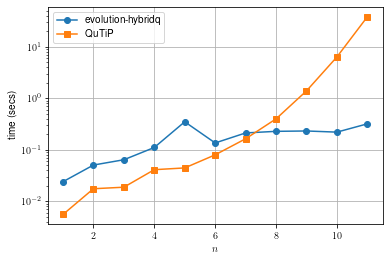

In [6]:
# now plot the results
fig, ax = plt.subplots(1)

ax.plot(sizes, timing_data['hq'], 'o-', label=backend)
ax.plot(sizes, timing_data['qt'], 's-', label='QuTiP')

ax.set_xlabel(r'$n$')
ax.set_ylabel(r'time (secs)')
ax.grid()
ax.legend()
ax.set_yscale('log')

### Now we test the tensor contraction protocol. Here the aim is to extract the reduced density matrix of a single qubit. We apply a random quantum circuit with 1 or 2-local depolarizing noise after each gate.

In [6]:
N = 9
n_gates = 50
# single and two qubit depolarizing rates
p1 = 0.01
p2 = 0.015

# the tensor contraction summation indices
indices = 'abcdefghijklmno'

# get a random quantum circuit for N qubits and n_gates gates.
rqc = get_rqc(N, n_gates)

# final state, e.g. '.abc' (where '.' is not contracted)
fs = '.' + indices[0:N - 1]

# first noiseless sim. There are two ways to do this.
t1_hq_tn = time.time()
# we do it via 'tn' to demonstrate the code is working as expected
rho_ideal_hq = dm_simulate(rqc,
                           initial_state='+',
                           final_state=fs + fs,
                           optimize='tn')
t2_hq_tn = time.time()

# by pure state evolution and taking partial trace (can differ slightly due to precision)
t1_hq_pure = time.time()
rho_ideal_hq_pure = ptrace(np.reshape(simulate(rqc, '+'), (2**N, )), 0)
t2_hq_pure = time.time()

# noisy sim with tensor network contraction
t1_hq_noise = time.time()

# add depolarizing noise and simulate
noisy_circuit = add_depolarizing_noise(rqc, (p1, p2))
C = SuperCircuit(noisy_circuit)
rho_noise_hq = dm_simulate(C,
                           initial_state='+',
                           final_state=fs + fs,
                           optimize='tn')

t2_hq_noise = time.time()

print("rho_0 without noise from tn")
print(rho_ideal_hq)
print()
print("rho_0 without noise from pure state sim")
print(rho_ideal_hq_pure)
print()
print("rho_0 with noise")
print(rho_noise_hq)

print(
    f'\n  noiseless sim took time {t2_hq_tn - t1_hq_tn:.3f} s using tn, and {t2_hq_pure-t1_hq_pure:.3f} s using ptrace'
    f'\n  noisy sim took time {t2_hq_noise - t1_hq_noise:.3f} s')

Contracting tensor (li=2^9, mli=2^26.0):   0%|          | 0/1 [00:00<?, ?it/s]

/Users/jeff/opt/anaconda3/envs/hybridq/lib/python3.8/site-packages/hybridq/circuit/simulation/simulation.py:408: UserWarning: The system is too small to use optimize='evolution-hybridq'. Falling back to optimize='evolution-einsum'
  warn("The system is too small to use optimize='evolution-hybridq'. "
/Users/jeff/opt/anaconda3/envs/hybridq/lib/python3.8/site-packages/hybridq/gate/gate.py:444: UserWarning: Using default number of qubits 'n_qubits=1'.
  warn("Using default number of qubits 'n_qubits=1'.")


Contracting tensor (li=2^12, mli=2^26.0):   0%|          | 0/1 [00:00<?, ?it/s]

rho_0 without noise from tn
[[ 0.42610568+7.4505806e-09j -0.2131076 -4.4885106e-02j]
 [-0.21310762+4.4885121e-02j  0.5738943 -7.4505806e-09j]]

rho_0 without noise from pure state sim
[[ 0.42610556+0.j         -0.21310753-0.04488507j]
 [-0.21310753+0.04488507j  0.5738943 +0.j        ]]

rho_0 with noise
[[ 0.4312507 -2.2822033e-09j -0.19861482-4.1832481e-02j]
 [-0.19861478+4.1832436e-02j  0.5687492 +4.7585513e-09j]]

  noiseless sim took time 4.016 s using tn, and 0.603 s using ptrace
  noisy sim took time 3.101 s


In [8]:
# now run with qutip, and check same output.
# here we simply run the full simulation, and then trace out the other qubits.
plus = (qt.basis(2, 0) + qt.basis(2, 1)).unit()
psi = qt.tensor([plus] * N)
rho = qt.ket2dm(psi)

# now simulate. We do the noisy and noiseless separately
# first noise free pure state
t1_qt = time.time()
for g in rqc:
    nq = len(g.qubits)
    g_qt = expand_operator(qt.Qobj(g.matrix(), dims=[[2] * nq, [2] * nq]),
                           N,
                           targets=g.qubits)

    # apply gate then the noise channel.
    psi = g_qt * psi

# now trace out other qubits
rho_ideal_qt = psi.ptrace(0)
t2_qt = time.time()

# iterate over the Gate's in the rqc, and convert to qutip.Qobj type.
t1_qt_noise = time.time()
for g in rqc:
    nq = len(g.qubits)
    g_qt = expand_operator(qt.Qobj(g.matrix(), dims=[[2] * nq, [2] * nq]),
                           N,
                           targets=g.qubits)

    # apply gate then the noise channel.
    rho = g_qt * rho * g_qt.dag()
    Pd = p1 if nq == 1 else p2
    rho = qt_apply(rho, depolarizing_channel(Pd, nq), g.qubits)

# trace out other qubits
rho_noise_qt = rho.ptrace(0)
t2_qt_noise = time.time()

print("rho_0 (qutip) without noise")
print(rho_ideal_qt)

print()
print("rho_0 (qutip) with noise")
print(rho_noise_qt)

# check qutip and hybridq agree
np.testing.assert_array_almost_equal(rho_ideal_qt.full(), rho_ideal_hq)
np.testing.assert_array_almost_equal(rho_noise_qt.full(), rho_noise_hq)

print(f'\n  qutip noiseless sim took time {t2_qt - t1_qt:.3f} '
      f's.\n  noisy sim took {t2_qt_noise - t1_qt_noise:.3f} s')

rho_0 (qutip) without noise
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.42610571+1.44913722e-18j -0.21310762-4.48850695e-02j]
 [-0.21310762+4.48850695e-02j  0.57389429+5.55325891e-19j]]

rho_0 (qutip) with noise
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.43125076+0.j         -0.19861484-0.04183242j]
 [-0.19861484+0.04183242j  0.56874924+0.j        ]]

  qutip noiseless sim took time 0.162 s.
  noisy sim took 21.507 s
